In [1]:
from pathlib import Path
from mne_bids import get_entity_vals
import json
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import re

In [2]:
bids_root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/40Hz-30")   # Change this
deriv_dir = bids_root / "derivatives"

reference = "monopolar"

feature = "band-power"

In [3]:
subjects = get_entity_vals(bids_root, "subject")

In [4]:
band_power_map = dict()
for subject in subjects:
    subject_dir = deriv_dir / feature / reference / f"sub-{subject}"
    subject_fpath = subject_dir / f"sub-{subject}_ses-initialvisit_task-monitor_run-01_eeg_bandpower.json"
    try:
        with open(subject_fpath) as f:
            band_power = json.load(f)
    except FileNotFoundError:
        continue
    band_power_map[subject] = band_power

Flip the dictionary:

In [5]:
band_power_channels = dict()
for subject, sub_map in band_power_map.items():
    for frq_band, band_map in sub_map.items():
        for ch, band_power in band_map.items():
            new_key = f"{frq_band}_{ch}"
            if band_power_channels.get(new_key) is None:
                band_power_channels[new_key] = dict()
            band_power_channels[new_key][subject] = band_power

In [6]:
band_power_channels

{'delta_Fp1': {'001': 4.3685971929934184e-11,
  '002': 1.3157001052782901e-11,
  '003': 2.7370735991617803e-12,
  '004': 7.690090979335576e-12,
  '005': 3.3419737992621694e-12,
  '006': 1.0459845122117791e-10,
  '007': 1.7986059556820742e-10,
  '008': 3.0251151512840553e-12,
  '009': 1.2161437342869757e-11,
  '010': 4.017057038922458e-12,
  '011': 6.976558243165981e-11,
  '012': 2.378206517849364e-11,
  '013': 2.753096818981429e-13,
  '014': 4.916863400552025e-12,
  '015': 1.101993949633259e-11,
  '016': 7.915291272581836e-12,
  '017': 4.179511201579748e-12,
  '018': 1.4718261395962163e-11,
  '019': 3.025101213032635e-11,
  '020': 1.5070829310684788e-12,
  '021': 1.660036024636667e-11,
  '022': 2.4094787054457315e-12,
  '023': 2.4239990905028508e-11,
  '024': 3.4921855550290563e-12,
  '025': 2.428175022334789e-12,
  '026': 1.8295841187658948e-11,
  '101': 7.286058777280032e-12,
  '102': 1.2861843648180368e-11,
  '103': 2.8832614021664635e-10,
  '104': 3.799823246206147e-12,
  '105': 2.

Split the dictionary into groups

In [7]:
band_power_non_epilepsy = dict()
band_power_epilepsy_normal = dict()
band_power_epilepsy_abnormal = dict()
for band_channel, band_map in band_power_channels.items():
    for subject, band_power in band_map.items():
        if int(subject) < 100:
            if band_power_non_epilepsy.get(band_channel) is None:
                band_power_non_epilepsy[band_channel] = dict()
            band_power_non_epilepsy[band_channel][subject] = band_power
        elif int(subject) > 200:
            if band_power_epilepsy_abnormal.get(band_channel) is None:
                band_power_epilepsy_abnormal[band_channel] = dict()
            band_power_epilepsy_abnormal[band_channel][subject] = band_power
        else:
            if band_power_epilepsy_normal.get(band_channel) is None:
                band_power_epilepsy_normal[band_channel] = dict()
            band_power_epilepsy_normal[band_channel][subject] = band_power

In [8]:
n_non_epilepsy = len(band_power_non_epilepsy[next(iter(band_power_non_epilepsy))].keys())
n_epilepsy_normal = len(band_power_epilepsy_normal[next(iter(band_power_epilepsy_normal))].keys())
n_epilepsy_abnormal = len(band_power_epilepsy_abnormal[next(iter(band_power_epilepsy_abnormal))].keys())

In [9]:
band_power_df_non_epilepsy = pd.DataFrame.from_dict(band_power_non_epilepsy)
band_power_df_non_epilepsy['group'] = [0] * n_non_epilepsy
band_power_df_non_epilepsy['y'] = [0] * n_non_epilepsy
band_power_df_epilepsy_normal = pd.DataFrame.from_dict(band_power_epilepsy_normal)
band_power_df_epilepsy_normal['group'] = [1] * n_epilepsy_normal
band_power_df_epilepsy_normal['y'] = [0] * n_epilepsy_normal
band_power_df_epilepsy_abnormal = pd.DataFrame.from_dict(band_power_epilepsy_abnormal)
band_power_df_epilepsy_abnormal['group'] = [2] * n_epilepsy_abnormal
band_power_df_epilepsy_abnormal['y'] = [1] * n_epilepsy_abnormal
band_power_df = pd.concat([band_power_df_non_epilepsy, band_power_df_epilepsy_normal, band_power_df_epilepsy_abnormal])
col_names = band_power_df.columns
y = list(band_power_df['y'])
group_inds = list(band_power_df['group'])
band_power_df

,delta_Fp1,delta_Fp2,delta_F3,delta_F4,delta_C3,delta_C4,delta_P3,delta_P4,delta_O1,delta_O2,...,beta_F8,beta_T3,beta_T4,beta_T5,beta_T6,beta_Fz,beta_Cz,beta_Pz,group,y
001,4.368597e-11,2.768208e-11,1.964183e-11,1.154315e-11,2.046265e-12,2.047812e-12,8.992058e-12,7.110746e-12,2.085716e-11,1.854886e-11,...,5.248493e-12,4.728770e-12,8.360094e-12,8.697198e-12,9.138453e-12,5.653906e-12,3.463611e-12,2.376442e-12,0,0
002,1.315700e-11,1.391617e-11,8.350684e-12,6.044455e-12,1.048621e-12,1.062600e-12,3.661021e-12,3.071107e-12,8.591736e-12,6.964763e-12,...,1.509511e-11,1.256571e-11,1.247685e-11,1.839971e-11,1.862507e-11,5.239010e-12,1.602610e-12,6.080928e-12,0,0
003,2.737074e-12,2.356392e-12,1.369340e-12,1.623130e-12,7.112002e-13,7.146262e-13,1.605970e-12,2.093238e-12,3.653992e-12,3.945242e-12,...,5.541327e-12,6.531287e-12,6.860108e-12,6.596429e-12,5.864939e-12,3.567868e-12,2.123469e-12,2.325385e-12,0,0
004,7.690091e-12,7.676334e-12,5.543020e-12,6.259721e-12,6.175592e-13,6.176030e-13,1.976569e-12,3.140476e-12,4.191096e-12,5.110573e-12,...,1.877265e-11,1.213952e-11,1.170471e-11,1.490035e-11,1.868248e-11,2.133565e-11,7.205153e-12,1.033526e-11,0,0
005,3.341974e-12,4.072543e-12,9.090744e-13,1.877538e-12,8.318354e-13,8.267329e-13,3.242545e-12,3.231701e-12,1.202286e-11,1.399498e-11,...,5.559869e-12,8.347814e-12,7.476215e-12,1.786519e-11,1.353092e-11,1.264176e-12,2.234731e-12,1.704984e-12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1.145998e-10,1.013591e-10,5.906745e-11,3.479298e-11,1.977177e-11,1.987273e-11,3.502792e-11,4.851294e-11,6.379069e-11,8.748434e-11,...,4.501520e-12,5.330617e-12,3.160499e-12,6.001703e-12,8.859099e-12,9.035381e-13,NaN,NaN,2,1
224,5.374483e-11,5.995174e-11,3.091963e-11,3.685956e-11,1.344365e-11,1.360634e-11,2.234900e-11,2.753319e-11,4.988378e-11,4.853808e-11,...,7.026024e-12,7.130608e-12,5.390564e-12,6.186612e-12,1.043940e-11,6.748129e-12,5.015061e-12,3.133555e-12,2,1
225,7.328497e-12,5.817070e-12,4.296944e-12,2.668167e-12,1.019189e-12,1.015426e-12,3.392135e-12,3.076552e-12,5.209231e-12,8.254700e-12,...,6.879130e-12,4.930343e-12,6.394490e-12,1.159102e-11,1.304524e-11,4.094626e-13,NaN,NaN,2,1
226,1.750101e-11,1.400829e-11,1.018086e-11,1.357728e-11,7.023991e-12,6.985891e-12,5.837110e-12,3.995211e-12,8.329895e-12,8.646253e-12,...,4.847396e-12,3.932606e-12,3.213430e-12,3.934509e-12,2.741864e-12,2.393898e-12,9.171452e-13,1.191676e-12,2,1


In [10]:
band_power_df_data = band_power_df.drop(['y', 'group'], axis=1)
#band_power_df_data = band_power_df_data.join(spike_channel_df, how='inner')
feat_names = band_power_df_data.columns
band_power_df_data

,delta_Fp1,delta_Fp2,delta_F3,delta_F4,delta_C3,delta_C4,delta_P3,delta_P4,delta_O1,delta_O2,...,beta_O2,beta_F7,beta_F8,beta_T3,beta_T4,beta_T5,beta_T6,beta_Fz,beta_Cz,beta_Pz
001,4.368597e-11,2.768208e-11,1.964183e-11,1.154315e-11,2.046265e-12,2.047812e-12,8.992058e-12,7.110746e-12,2.085716e-11,1.854886e-11,...,9.922815e-12,6.302582e-12,5.248493e-12,4.728770e-12,8.360094e-12,8.697198e-12,9.138453e-12,5.653906e-12,3.463611e-12,2.376442e-12
002,1.315700e-11,1.391617e-11,8.350684e-12,6.044455e-12,1.048621e-12,1.062600e-12,3.661021e-12,3.071107e-12,8.591736e-12,6.964763e-12,...,1.589412e-11,1.437062e-11,1.509511e-11,1.256571e-11,1.247685e-11,1.839971e-11,1.862507e-11,5.239010e-12,1.602610e-12,6.080928e-12
003,2.737074e-12,2.356392e-12,1.369340e-12,1.623130e-12,7.112002e-13,7.146262e-13,1.605970e-12,2.093238e-12,3.653992e-12,3.945242e-12,...,4.653661e-12,9.327204e-12,5.541327e-12,6.531287e-12,6.860108e-12,6.596429e-12,5.864939e-12,3.567868e-12,2.123469e-12,2.325385e-12
004,7.690091e-12,7.676334e-12,5.543020e-12,6.259721e-12,6.175592e-13,6.176030e-13,1.976569e-12,3.140476e-12,4.191096e-12,5.110573e-12,...,1.909676e-11,2.012975e-11,1.877265e-11,1.213952e-11,1.170471e-11,1.490035e-11,1.868248e-11,2.133565e-11,7.205153e-12,1.033526e-11
005,3.341974e-12,4.072543e-12,9.090744e-13,1.877538e-12,8.318354e-13,8.267329e-13,3.242545e-12,3.231701e-12,1.202286e-11,1.399498e-11,...,1.633573e-11,8.872934e-12,5.559869e-12,8.347814e-12,7.476215e-12,1.786519e-11,1.353092e-11,1.264176e-12,2.234731e-12,1.704984e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,1.145998e-10,1.013591e-10,5.906745e-11,3.479298e-11,1.977177e-11,1.987273e-11,3.502792e-11,4.851294e-11,6.379069e-11,8.748434e-11,...,6.747869e-12,6.761752e-12,4.501520e-12,5.330617e-12,3.160499e-12,6.001703e-12,8.859099e-12,9.035381e-13,NaN,NaN
224,5.374483e-11,5.995174e-11,3.091963e-11,3.685956e-11,1.344365e-11,1.360634e-11,2.234900e-11,2.753319e-11,4.988378e-11,4.853808e-11,...,8.664474e-12,6.829139e-12,7.026024e-12,7.130608e-12,5.390564e-12,6.186612e-12,1.043940e-11,6.748129e-12,5.015061e-12,3.133555e-12
225,7.328497e-12,5.817070e-12,4.296944e-12,2.668167e-12,1.019189e-12,1.015426e-12,3.392135e-12,3.076552e-12,5.209231e-12,8.254700e-12,...,1.230653e-11,6.735823e-12,6.879130e-12,4.930343e-12,6.394490e-12,1.159102e-11,1.304524e-11,4.094626e-13,NaN,NaN
226,1.750101e-11,1.400829e-11,1.018086e-11,1.357728e-11,7.023991e-12,6.985891e-12,5.837110e-12,3.995211e-12,8.329895e-12,8.646253e-12,...,3.633401e-12,4.349696e-12,4.847396e-12,3.932606e-12,3.213430e-12,3.934509e-12,2.741864e-12,2.393898e-12,9.171452e-13,1.191676e-12


In [11]:
band_power_df = band_power_df_data.copy()

In [12]:
band_power_arr = band_power_df.to_numpy(na_value=0.0)
X = band_power_arr

In [13]:
X = preprocessing.normalize(X, norm='l2', axis=0)
print(X.shape)
selector = SelectKBest(chi2, k=6)
X_new = selector.fit_transform(X, y)
feat_bool = selector.get_support()
chosen_feats = feat_names[feat_bool]
chosen_feats

(75, 76)


Index(['delta_Fp1', 'delta_F7', 'delta_T3', 'delta_T4', 'theta_T3',
       'theta_T4'],
      dtype='object')

In [14]:
clf = LogisticRegression(random_state=0).fit(X_new, y)
coef_ = clf.coef_
intercept = clf.intercept_

In [15]:
coeffs = [intercept[0]]
[coeffs.append(c) for c in coef_[0]]
coeffs

[-0.8007307551652971,
 0.450789581927209,
 0.7118010226956605,
 0.6368826280463965,
 0.6906973085066945,
 0.5658292630533,
 0.5454534987363634]

In [16]:
X_inner = np.hstack((np.ones((len(y), 1)), X_new))
inner = np.dot(X_inner, coeffs)
    
phat = np.divide(np.exp(inner), 1 + np.exp(inner))

In [17]:
phat_arr = np.array(phat)
phat_non_epilepsy = phat_arr[group_inds == 0]
phat_epilepsy_normal = phat_arr[group_inds == 1]
phat_epilepsy_abnormal = phat_arr[group_inds == 2]

In [18]:
x = [np.random.normal(g, 0.04, size=1)[0] for g in group_inds]
plotting_df = pd.DataFrame()
plotting_df['prediction'] = phat_arr
plotting_df['X'] = x
plotting_df['Group'] = group_inds

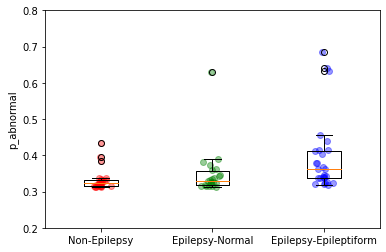

In [19]:
df = plotting_df.copy()
handles = []
fig, ax = plt.subplots()
vals, names, xs = [], [], []
for ind in range(3):
    group = df[df.Group == ind]
    vals.append(group['prediction'].values)
    names.append(str(ind))
    xs.append(group['X'].values)
ax.boxplot(vals, labels=names)

palette = ['r', 'g', 'b']

for x, val, c in zip(xs, vals, palette):
    handle = ax.scatter(x+1, val, alpha=0.4, color=c, label='Normal Spikes')
    handles.append(handle)

ax.set_xticklabels(['Non-Epilepsy', 'Epilepsy-Normal', 'Epilepsy-Epileptiform'])
ax.set_ylabel('p_abnormal')
ax.set_ylim([0.2, 0.8])
plt.show()